In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

c:\Users\maxmi\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import der Daten
Der bereits vorgestellte IMDb Datensatz ist im tensorflow_dataset zur verfügung gestellt und wir hier erstmals geladen.


In [2]:
# Laden der IMDB Reviews-Daten mit Infos und als betreute Daten (X, y)
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

# Anzahl der Trainingsbeispiele aus den Datensatz holen
train_size = info.splits["train"].num_examples

## Vorverarbeitung der Daten

## Aufgabe 1:
Schreibe die Funktion preprocess fertig die Folgende Dinge gemäß der Präsentation macht:<br>
1. Länge auf 300 chars kürzen <br>
2. alle html Tags ersetzt <br>
3. alle Satzzeichen bis auf Buchstaben und Apostrophe ersetzt <br>
<br>

Hint: Dafür sind die Funktionen tf.strings.substr und tf.strings.regex_replace hilfreich

In [3]:
def preprocess(X_batch, y_batch):
    #To Do:
    X_batch = 
    X_batch = 
    X_batch = 
    # Aufteilen der Strings in einzelne Wörter
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

<h3> Aufkommen der Wörter zählen</h3>
In Batches der Größe 32 aufteilen - Ein Batch enthält 32 Reviews <br>
Anschließend wird das Aufkommen der verschiedenen Wörter gezählt und gespeichert

In [4]:
from collections import Counter

# Vokabular initialisieren
vocabulary = Counter()

# Durchlaufen der Trainingsdaten in Batches von 32 und Anwenden der preprocess-Funktion
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    # Für jede Rezension im Batch
    for review in X_batch:
        # Vokabular mit den Wörtern der Rezension aktualisieren
        vocabulary.update(list(review.numpy()))

# Die drei häufigsten Wörter im Vokabular anzeigen
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

Hier wird die Vokabulargröße auf 10.000 Wörter festgelegt und Wörter entsprechend der Frequenz zugeordnet.

In [5]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

<h3>Lookup Tabelle erstellen und Word ID's und OOV-Buckets mappen</3>

In [6]:
# Konvertieren der Wörter des gekürzten Vokabulars in ein Tensor
words = tf.constant(truncated_vocabulary)

# Erzeugen einer Liste von IDs für die Wörter
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

# Initialisieren der Lookup-Tabelle mit Wörtern und deren IDs
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

# Anzahl der Buckets für unbekannte Wörter festlegen
num_oov_buckets = 1000

# Erstellen einer statischen Vokabulartabelle mit Unterstützung für unbekannte Wörter
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)


<h3>Beispielhafte Codierung</h3>

In [7]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]], dtype=int64)>

<h3>Trainingsdatensatz erstellen</h3>

In [8]:
# Funktion zum Kodieren der Wörter
def encode_words(X_batch, y_batch):
    # Wörter in IDs umwandeln und Labels unverändert zurückgeben
    return table.lookup(X_batch), y_batch

# Trainingsdatensatz in Batches von 32 aufteilen und preprocess-Funktion anwenden
train_set = datasets["train"].batch(32).map(preprocess)

# Wörter im Trainingsdatensatz kodieren und Daten für effizienteres Training vorab laden
train_set = train_set.map(encode_words).prefetch(1)

## Checkpoint: Erste Hälfte geschafft, jetzt geht die Präsentation erstmal weiter

<h3>Netzwerk Konstruieren</h3>

## Aufgabe 2:

Füge die beiden GRU-Layer entsprechend der Präsentation ein

Hint: Dazu hilft die Dokumentation von keras.layers.GRU()

In [9]:
embed_size = 128
# Modell mit Sequenziellen Schichten definieren
model = keras.models.Sequential([
    # Embedding-Schicht hinzufügen, die Wörter in dichte Vektoren umwandelt
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
    input_shape=[None]),
    #To Do:
    # GRU Layer 1
    
    # GRU Layer 2
    
    # Dichte Schicht mit einem Neuron und Sigmoid-Aktivierung für binäre Klassifikation
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
    metrics=["accuracy"])
# Modell auf dem Trainingsdatensatz trainieren für 5 Epochen
history = model.fit(train_set, epochs=4)

Epoch 1/4


c:\Users\maxmi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 98s 121ms/step - accuracy: 0.5377 - loss: 0.6757
Epoch 2/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 76s 97ms/step - accuracy: 0.7958 - loss: 0.4417
Epoch 3/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 91s 117ms/step - accuracy: 0.8885 - loss: 0.2762
Epoch 4/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 91s 117ms/step - accuracy: 0.9374 - loss: 0.1726


<h3>Plotten der performance</h3>

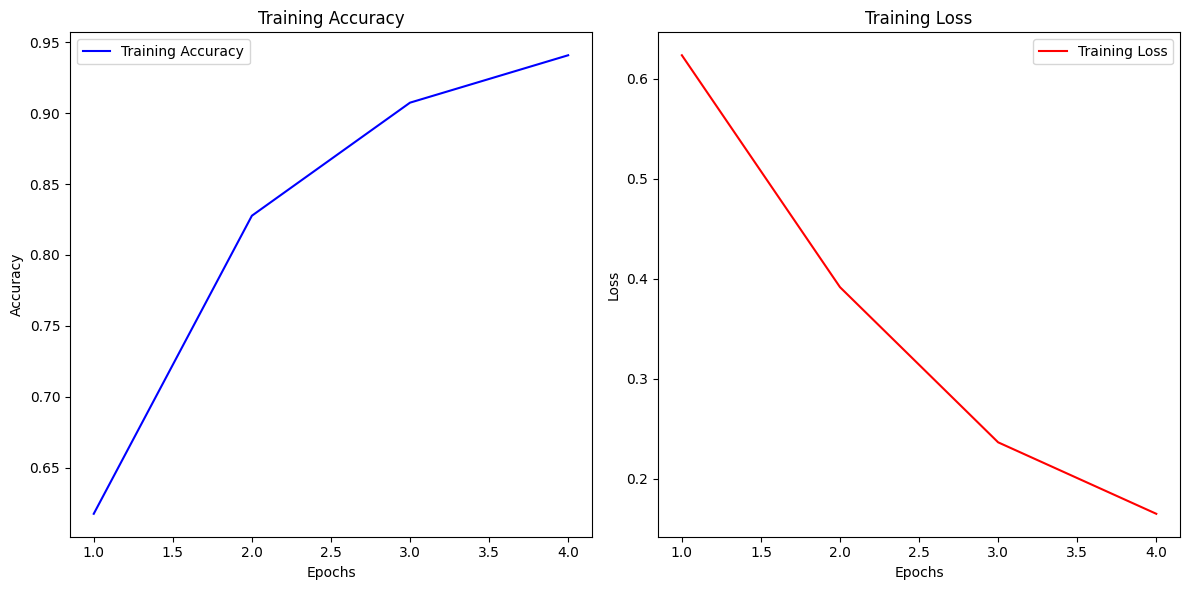

In [10]:
accuracy = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Testbereich
Hier könnt ihr ein wenig mit eurem selbst erstellten Netzwerk für die Sentiment Analyse herumexperimentieren!

In [14]:
example_sentence = "The movie was the worst I have ever seen<br></br>"

# Preprocessing des Beispielsatzes
def preprocess_sentence(sentence):
    sentence = tf.strings.substr(sentence, 0, 300)
    sentence = tf.strings.regex_replace(sentence, b"<br\\s*/?>", b" ")
    sentence = tf.strings.regex_replace(sentence, b"[^a-zA-Z']", b" ")
    sentence = tf.strings.split(sentence)
    return sentence.to_tensor(default_value=b"<pad>")

# Encodieren des Beispielsatzes
def encode_sentence(sentence):
    preprocessed_sentence = preprocess_sentence(sentence)
    encoded_sentence = table.lookup(preprocessed_sentence)
    #print(encoded_sentence)
    return encoded_sentence

# Vorhersage für den Beispielsatz
def predict_sentence(sentence):
    encoded_sentence = encode_sentence(tf.constant([sentence]))
    prediction = model.predict(encoded_sentence)
    return prediction

# Vorhersage für den Beispielhafter Satz
prediction = predict_sentence(example_sentence)

print(f"Vorhersage für den Satz '{example_sentence}': {prediction[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Vorhersage für den Satz 'The movie was the worst I have ever seen<br></br>': 0.0069
